In [4]:
# if necessary: install CLUS
# !pip install "pyclus-1.0.1+modified.kd-py3-none-any.whl"

In [1]:
import sys
import os
import itertools
import textwrap
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from pathlib import Path
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import root_mean_squared_error
from matplotlib.colors import LinearSegmentedColormap
from autorank import autorank, plot_stats, create_report

from sklearn.preprocessing import StandardScaler
import numpy as np

In [2]:
import subprocess
try:
    java_version = subprocess.check_output(['java', '-version'], stderr=subprocess.STDOUT)
except FileNotFoundError:
    print('Java is not installed on your computer. Please download it from https://www.oracle.com/java/technologies/downloads and install it.')

In [3]:
import clus_util

In [4]:
#Mute warning during training for clean log outputs
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [5]:
#Irrelevent features
config_key=["dataset_random_state","n_samples","n_informative","n_redundant","n_repeated","n_classes",
            "class_imbalanced",
            "n_clusters_per_class", "positive_class_num", "sensitive_random_state", "continous_groups", 
            "sensitive_imbalanced",
            "n_group", "group_dimension", "k", "prev_weight", "random_walk", "coefficient", 
            "landmarking_random_state","n_features",
            "class_weight","sensitive_group_scores"]
#Target Labels
bias_score_key=["Group Size Disparity","Prevalence Disparity","equal_opportunity","disparate_parity","individual_fairness","group_fairness"]
targets=['disparate_parity', 'equal_opportunity', 'group_fairness']
target_names = ['Disparate Parity', 'Equal Opportunity', 'Group Fairness']
target_names_w = [textwrap.fill(name, width=10, break_long_words=False) for name in target_names]
target_names_dict_w = dict(zip(targets, target_names_w))
target_names_dict = dict(zip(targets, target_names))

In [6]:
sns.set_style("ticks")
plt.rcParams.update({"text.usetex": True, "font.family": "serif", "font.size": 9})
sns.set_style(rc={"font.size": 8})
COLORS = ['#00678a', '#984464', '#5eccab', '#56641a', '#e6a176', '#c0affb']

In [7]:
df=pd.read_csv("artifact/metadataset.csv")
df=df.drop(config_key,axis=1)
X=df.drop(bias_score_key,axis=1)
Y=df[targets]

#### Regression Chains

In [28]:
#KFold parameters of the whole cross validation experiments
fold_settings={
    "n_splits":10, 
    "shuffle":True,
    "random_state":420
}

numbers_of_trees = [50, 100, 200]
# numbers_of_trees = list(range(100,300,50))
# numbers_of_trees = [3, 5, 10, 15, 20, 30, 50]

In [ ]:
# targets scaled
scaler = StandardScaler()
Y_scaled = pd.DataFrame(scaler.fit_transform(Y), index=Y.index, columns=Y.columns)

results = []
for trees in numbers_of_trees:
    for index,(train_index,test_index) in enumerate(KFold(**fold_settings).split(X,Y_scaled)):
        Y_true_scaled, Y_pred_scaled, importances = clus_util.run_clus(X, Y_scaled, test_index, seed=42, 
                                                                   n_trees=trees, tempdir="test", appendix='_'+str(index))
        Y_true = scaler.inverse_transform(Y_true_scaled)
        Y_pred = scaler.inverse_transform(Y_pred_scaled)

        for t, target in enumerate(targets):
            res = {'Fold': index, 'Model': f'CLUS ({trees})', 'Chain': None, 'label': target,
                   'RMSE': root_mean_squared_error(Y_true[:,t], Y_pred[:,t])}
            results.append(res)
            print(res)
        res = {'Fold': index, 'Model': f'CLUS ({trees})', 'Chain': None, 'label': 'all',
               'RMSE': root_mean_squared_error(Y_true, Y_pred)}
        results.append(res)
    
pd.DataFrame(results).to_csv('experiment_result/Q3_CLUS_minimal.csv', index=False)

In [29]:
# targets not scaled
results = []
for trees in numbers_of_trees:
    for index,(train_index,test_index) in enumerate(KFold(**fold_settings).split(X,Y)):
        Y_true, Y_pred, importances = clus_util.run_clus(X, Y, test_index, seed=42, 
                                                         n_trees=trees, tempdir="test", appendix='_'+str(index))

        for t, target in enumerate(targets):
            res = {'Fold': index, 'Model': f'CLUS ({trees})', 'Chain': None, 'label': target,
                   'RMSE': root_mean_squared_error(Y_true[:,t], Y_pred[:,t])}
            results.append(res)
            print(res)
        res = {'Fold': index, 'Model': f'CLUS ({trees})', 'Chain': None, 'label': 'all',
               'RMSE': root_mean_squared_error(Y_true, Y_pred)}
        results.append(res)
    
pd.DataFrame(results).to_csv('experiment_result/Q3_CLUS_minimal.csv', index=False)

{'Fold': 0, 'Model': 'CLUS (50)', 'Chain': None, 'label': 'disparate_parity', 'RMSE': 0.14752002988585128}
{'Fold': 0, 'Model': 'CLUS (50)', 'Chain': None, 'label': 'equal_opportunity', 'RMSE': 0.1766965353750327}
{'Fold': 0, 'Model': 'CLUS (50)', 'Chain': None, 'label': 'group_fairness', 'RMSE': 0.07276324199180702}
{'Fold': 1, 'Model': 'CLUS (50)', 'Chain': None, 'label': 'disparate_parity', 'RMSE': 0.14545153604258068}
{'Fold': 1, 'Model': 'CLUS (50)', 'Chain': None, 'label': 'equal_opportunity', 'RMSE': 0.16451984213873122}
{'Fold': 1, 'Model': 'CLUS (50)', 'Chain': None, 'label': 'group_fairness', 'RMSE': 0.07285083874244647}
{'Fold': 2, 'Model': 'CLUS (50)', 'Chain': None, 'label': 'disparate_parity', 'RMSE': 0.13689515954189505}
{'Fold': 2, 'Model': 'CLUS (50)', 'Chain': None, 'label': 'equal_opportunity', 'RMSE': 0.16248925363814865}
{'Fold': 2, 'Model': 'CLUS (50)', 'Chain': None, 'label': 'group_fairness', 'RMSE': 0.07387291233393606}
{'Fold': 3, 'Model': 'CLUS (50)', 'Chain'

In [30]:
# df_res = pd.read_csv('experiment_result/Q3_CLUS_all_params_scaled.csv')
df_res = pd.read_csv('experiment_result/Q3_CLUS_minimal.csv')

In [31]:
# parameter comparison: 
## more is always better, but it's unfair to give CLUS more trees than its competitors
df_res[df_res['label']=='all'][['Model', 'RMSE']].groupby(by='Model').mean()

,RMSE
Model,
CLUS (100),0.127102
CLUS (200),0.127009
CLUS (50),0.127319


### Comparison Single-Target vs. Multi-Target

In [32]:
df_results = pd.read_csv('experiment_result/Q3_chain_ensemble_minimal.csv')
df_results = df_results.rename({'Target': 'label'}, axis=1)

In [33]:
df_ensemble = df_results[df_results["Model"] == "Ensemble"]
df_chain_best = df_results[df_results["Model"] == "Chain"].loc[
    df_results[df_results["Model"] == "Chain"].groupby(["Fold", "label"])["RMSE"].idxmin()
]
df_chain_best['Model'] = 'BestChain'
df_clus = df_res[df_res['Model'] == 'CLUS (200)']
df_clus = df_clus[df_clus["label"] != "all"]
df_clus['Model'] = 'CLUS'
df_multi = pd.concat([df_chain_best, df_ensemble, df_clus])

In [34]:
df_single = pd.read_csv("experiment_result/Q2_result.csv", index_col=0)
df_single = df_single[['Model', 'Fold', 'label', 'RMSE']]
df_single = df_single[df_single['Model'].isin(['NaiveMean', 'LinearRegression', 'Lasso', 'XGBoost',
       'LightGBM', 'RandomForest', 'MLP'])]
df_single = df_single[df_single['label'].isin(targets)]
# df_single_avg = df_single.groupby(by=['Model', 'Fold'])['RMSE'].mean().reset_index()

In [35]:
# df_concat = pd.concat([df_single_avg, df_multi.drop(['Chain'], axis=1)]).reset_index(drop=True)
df_concat = pd.concat([df_single, df_multi.drop(['Chain'], axis=1)]).reset_index(drop=True)
df_piv = df_concat.pivot(index=['Fold', 'label'], columns='Model', values='RMSE')

In [36]:
result = autorank(-df_piv, alpha=0.01)
# result = autorank(-pd.concat([df_piv, df_piv]).reset_index().drop(['Fold'], axis=1), alpha=0.01)

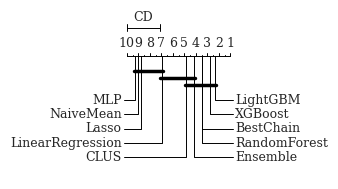

In [37]:
plt.rc('text', usetex=False)
fig, ax = plt.subplots(1, 1, figsize=(2,2.2))
# fig, ax = plt.subplots(1, 1, figsize=(6,4))
plot_stats(result, ax=ax)
plt.savefig('Plots/Q3/single_and_ensemble_CD_plot_with_CLUS.pdf', bbox_inches='tight')
plt.show()

### Separate results per target

In [38]:
df_concat.groupby(by=['label', 'Model']).mean()

Fold      RMSE
label             Model                           
disparate_parity  BestChain          4.5  0.128992
                  CLUS               4.5  0.140272
                  Ensemble           4.5  0.129259
                  Lasso              4.5  0.162242
                  LightGBM           4.5  0.128959
                  LinearRegression   4.5  0.148422
                  MLP                4.5  0.162325
                  NaiveMean          4.5  0.162289
                  RandomForest       4.5  0.129462
                  XGBoost            4.5  0.129369
equal_opportunity BestChain          4.5  0.158559
                  CLUS               4.5  0.167457
                  Ensemble           4.5  0.158499
                  Lasso              4.5  0.179059
                  LightGBM           4.5  0.157528
                  LinearRegression   4.5  0.172977
                  MLP                4.5  0.179230
                  NaiveMean          4.5  0.179061
                  RandomForest       4.5  0.159211
                  XGBoost            4.5  0.158291
group_fairness    BestChain          4.5  0.075104
                  CLUS               4.5  0.073298
                  Ensemble           4.5  0.075902
                  Lasso              4.5  0.414204
                  LightGBM           4.5  0.073563
                  LinearRegression   4.5  0.338103
                  MLP                4.5  0.414353
                  NaiveMean          4.5  0.414245
                  RandomForest       4.5  0.073265
                  XGBoost            4.5  0.073343